In [1]:
# import libraries
from neo4j import GraphDatabase
import pandas as pd

In [2]:
# connect to the neo4j server, here the community edition 4.3.6 is used
user = "neo4j"
password = "xxxx"  # change your password
driver = GraphDatabase.driver("bolt://localhost:7687", auth=(user, password))

## Create Graph

In [3]:
# load the csv files of transport nodes and transport relationships
with driver.session() as session:
    session.run("""
    LOAD CSV WITH HEADERS FROM "file:///data/transport-nodes.csv" AS row
    MERGE (place:Place {id:row.id})
    SET place.latitude = toFloat(row.latitude),
        place.longitude = toFloat(row.longitude),
        place.population = toInteger(row.population)
    """)
    
    session.run("""
    WITH "file:///data/transport-relationships.csv" AS uri
    LOAD CSV WITH HEADERS FROM uri AS row
    MATCH (origin:Place {id: row.src})
    MATCH (destination:Place {id: row.dst})
    MERGE (origin)-[:EROAD {distance: toInteger(row.cost)}]->(destination)
    """)

Create in-memory graph.

In [4]:
create_memory_graph_query = """
CALL gds.graph.create(
    'transport', 
    {
        Place: {properties: ['latitude', 'longitude', 'population']}
    },
    { EROAD:
        {
            properties: 'distance'
        }
    }
)
"""

In [5]:
with driver.session() as session:
    session.run(create_memory_graph_query)

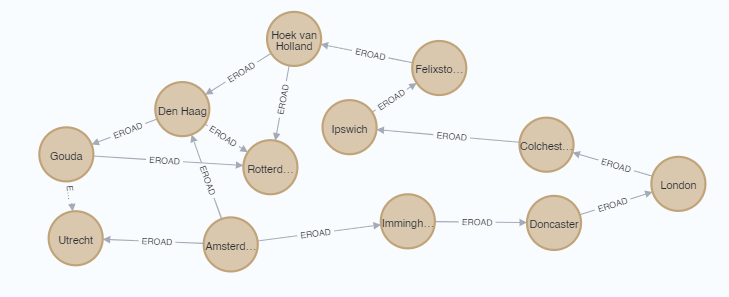

## Shortest Path (Weighted)

Execute the shortest path: Dijkstra Source-Target algorithm to find the shortest path from Amtersdam to London, given the cost as the weights. 

In [6]:
query = """
        MATCH (source:Place {id: $source}), (destination:Place {id: $destination})
        CALL gds.shortestPath.dijkstra.stream('transport', {
            sourceNode: source, 
            targetNode: destination, 
            relationshipWeightProperty: 'distance'
        })
        YIELD nodeIds, sourceNode, targetNode, costs, totalCost
        RETURN
            [nodeId IN nodeIds | gds.util.asNode(nodeId).id] AS place,
            costs,
            totalCost
"""

params = {
    "source": "Amsterdam",
    "destination": "London"
}

In [7]:
with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

In [8]:
df

,place,costs,totalCost
0,"[Amsterdam, Immingham, Doncaster, London]","[0.0, 369.0, 443.0, 720.0]",720.0


In [9]:
df['place'][0]

['Amsterdam', 'Immingham', 'Doncaster', 'London']

The shortest path from Asterdam to London based on the cost is "'Amsterdam', 'Immingham', 'Doncaster', 'London'", the total cost is 720. Note that the graph is directed.

## Shortest Path Variation: A* Algorithm

The A* Shortest Path algorithm improves on Dijkstra’s by finding shortest paths more quickly. It does this by allowing the inclusion of extra information that the algorithm can use, as part of a heuristic function, when determining which paths to explore next.In Neo4j’s implementation, geospatial distance is used as the heuristic. In the example transportation dataset we use the latitude and longitude of each location as part of the heuristic function.

In [10]:
astar_query = """
        MATCH (source:Place {id: $source}), (destination:Place {id: $destination})
        CALL gds.shortestPath.astar.stream('transport', {
            sourceNode: source, 
            targetNode: destination, 
            relationshipWeightProperty: 'distance',
            latitudeProperty: 'latitude',
            longitudeProperty: 'longitude'
        })
        YIELD nodeIds, sourceNode, targetNode, costs, totalCost
        RETURN
            [nodeId IN nodeIds | gds.util.asNode(nodeId).id] AS place,
            costs,
            totalCost
"""

params = {
    "source": "Amsterdam",
    "destination": "London"
}

In [11]:
with driver.session() as session:
    rows = session.run(astar_query, params)
    astar_df = pd.DataFrame([dict(record) for record in rows])

In [12]:
astar_df

,place,costs,totalCost
0,"[Amsterdam, Immingham, Doncaster, London]","[0.0, 369.0, 443.0, 720.0]",720.0


The shortest path using A* algorithm and Dijkstra algorithm is the same. 

## Shortest Path Variation: Yen's k-Shortest Paths

Yen’s k-Shortest Paths algorithm is similar to the Shortest Path algorithm, but rather than finding just the shortest path between two pairs of nodes, it also calculates the second shortest path, third shortest path, and so on up to k-1 deviations of shortest paths. Find the 5 shortest path between Amsterdam and Den Haag. 

In [16]:
yen_query = """
    MATCH (source:Place {id: $source}), (destination:Place {id: $destination})
        CALL gds.shortestPath.yens.stream('transport', {
            sourceNode: source, 
            targetNode: destination, 
            k: 5,
            relationshipWeightProperty: 'distance'
        })
        YIELD nodeIds, sourceNode, targetNode, costs, totalCost
        RETURN
            [nodeId IN nodeIds | gds.util.asNode(nodeId).id] AS place,
            costs,
            totalCost
"""

params = {
    "source": "Amsterdam",
    "destination": "Den Haag"
}

In [17]:
with driver.session() as session:
    rows = session.run(yen_query, params)
    yen_df = pd.DataFrame([dict(record) for record in rows])

In [18]:
pd.set_option('max_colwidth', 100)
display(yen_df)

,place,costs,totalCost
0,"[Amsterdam, Den Haag]","[0.0, 59.0]",59.0
1,"[Amsterdam, Immingham, Doncaster, London, Colchester, Ipswich, Felixstowe, Hoek van Holland, Den...","[0.0, 369.0, 443.0, 720.0, 826.0, 858.0, 880.0, 1087.0, 1114.0]",1114.0


Notice that there are only two paths from Amsterdam to Den Haag. The first path is obviously more shorter than the second path. 

## Random Walk

The Random Walk algorithm provides a set of nodes on a random path in a graph.

In [31]:
rw_query = """
    MATCH (source:Place {id: $place})
    CALL gds.beta.randomWalk.stream('transport',
    {
        walkLength: 3,
        walksPerNode: 1,
        randomSeed: 42,
        concurrency: 1
    })
    YIELD nodeIds, path
    RETURN [nodeId IN nodeIds | gds.util.asNode(nodeId).id] AS place
"""

params = {
    "place": "Amsterdam"
}

In [32]:
with driver.session() as session:
    rows = session.run(rw_query, params)
    rw_df = pd.DataFrame([dict(record) for record in rows])

In [33]:
rw_df

,place
0,"[Amsterdam, Immingham, Doncaster]"
1,"[Den Haag, Gouda, Rotterdam]"
2,"[Immingham, Doncaster, London]"
3,"[Doncaster, London, Colchester]"
4,"[Hoek van Holland, Rotterdam]"
5,"[Felixstowe, Hoek van Holland, Rotterdam]"
6,"[Ipswich, Felixstowe, Hoek van Holland]"
7,"[Colchester, Ipswich, Felixstowe]"
8,"[London, Colchester, Ipswich]"
9,"[Gouda, Rotterdam]"


At each stage of the random walk, the next relationship is randomly chosen. If we rerun the algorithm, even with the same parameters, the result will be different. 

### Acknowledgement

This jupyter notebook is modified based on the book "Graph Algorithms: Practical Examples in Apache Spark & Neo4j", written by Mark Needham and Amy E. Hodler. However, the graph algorithm library used in this book is out to date, the current library used is the Graph Data Science library: https://neo4j.com/docs/graph-data-science/current/algorithms/